In [1]:
# IPython log file
import fiftyone as fo
import fiftyone.zoo as foz
# pycocotools
import json
import time
import matplotlib; matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

In [2]:
classes = ["car", "bicycle", "motorcycle", "bus", "dog", "cat"]
dataset = fo.zoo.load_zoo_dataset("coco-2017",
                                  split="train",
                                  classes=classes,
                                  max_samples=25151
)

test = fo.zoo.load_zoo_dataset("coco-2017",
                              split="test",
                              classes = classes,
                               max_samples = 5030)

Found annotations at 'C:\Users\patri\fiftyone\coco-2017\raw\instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train-25151'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Test split is unlabeled; ignoring classes requirement
Found test info at 'C:\Users\patri\fiftyone\coco-2017\raw\image_info_test2017.json'
Sufficient images already downloaded
Writing annotations for 6708 downloaded samples to 'C:\Users\patri\fiftyone\coco-2017\test\labels.json'
Dataset info written to 'C:\Users\patri\fiftyone\coco-2017\info.json'
Loading 'coco-2017' split 'test'
Dataset is unlabeled; ignoring classes requirement
 100% |███████████████| 5030/5030 [1.5s elapsed, 0s remaining, 3.4K samples/s]         
Dataset 'coco-2017-test-5030' created



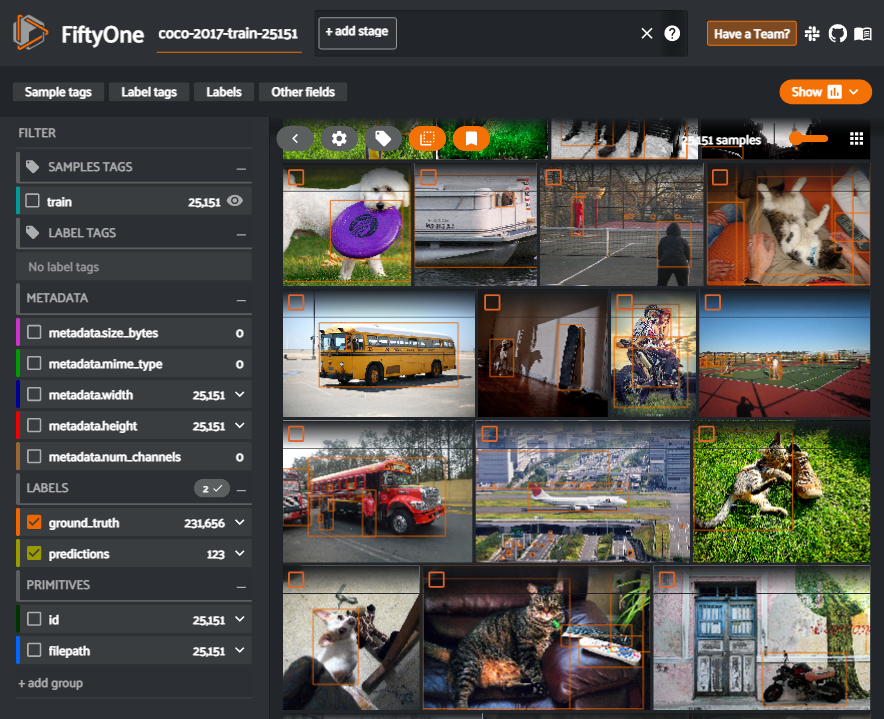

In [3]:
session = fo.launch_app(dataset)

In [4]:
sample = dataset.first()
print(sample.ground_truth.detections[0])

<Detection: {
    'id': '633d3ce0243c05c5dc10c9c9',
    'attributes': {},
    'tags': [],
    'label': 'dog',
    'bounding_box': [0.334609375, 0.0863807531380753, 0.54415625, 0.51],
    'mask': None,
    'confidence': None,
    'index': None,
    'supercategory': 'animal',
    'iscrowd': 0,
}>


In [5]:
import torch
import torchvision

# Run the model on GPU if it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

print("Model ready")

C:\Users\patri\anaconda3\envs\coco\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\patri\anaconda3\envs\coco\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model ready


In [21]:
# Choose a random subset of 100 samples to add predictions to
predictions_view = test.take(100, seed=51)

In [22]:
from PIL import Image
from torchvision.transforms import functional as func

import fiftyone as fo

# Get class list
classes = dataset.default_classes

# Add predictions to samples
with fo.ProgressBar() as pb:
    for sample in pb(predictions_view):
        # Load image
        image = Image.open(sample.filepath)
        image = func.to_tensor(image).to(device)
        c, h, w = image.shape

        # Perform inference
        preds = model([image])[0]
        labels = preds["labels"].cpu().detach().numpy()
        scores = preds["scores"].cpu().detach().numpy()
        boxes = preds["boxes"].cpu().detach().numpy()

        # Convert detections to FiftyOne format
        detections = []
        for label, score, box in zip(labels, scores, boxes):
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

            detections.append(
                fo.Detection(
                    label=classes[label],
                    bounding_box=rel_box,
                    confidence=score
                )
            )

        # Save predictions to dataset
        sample["predictions"] = fo.Detections(detections=detections)
        sample.save()

 100% |███████████████████| 10/10 [33.1s elapsed, 0s remaining, 0.3 samples/s]    


In [23]:
session.view = predictions_view

In [24]:
patches_view = predictions_view.to_patches("ground_truth")
print(patches_view)

Dataset:     coco-2017-test-5030
Media type:  image
Num patches: 0
Patch fields:
    id:           fiftyone.core.fields.ObjectIdField
    sample_id:    fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detection)
View stages:
    1. Take(size=10, seed=51)
    2. ToPatches(field='ground_truth', config=None)


In [25]:
session = fo.launch_app(view=patches_view)


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds

